# In Depth Discussion of the Business Prototyping Toolkit for Python

This in depth tutorial looks at the architecture of the Business Prototyping Toolkit for Python. We suppose you made yourself familiar with the ``plot_scenarios / dashboard`` API and now want to understand how things work internally. Furthermore it covers how to create scenarios and modify constants and equations during runtime.

As you already learned, the Business Prototyping Toolkit for Python comes with a model simulator and some methods to plot simulation results or obtain the raw results, a so-called API.

The API for plotting simulation is really simple. It only exposes one function. The simulations run in the background every time you call a plot method. For long and large simulations, please bear with me and bring a few seconds of patience before I plot. ;-) We try to optimize the simulation execution as much as possible but it may still take a while to generate results. Each API method comes with many parameters for modifying the graph. The standard settings however are in the config. They define the common "transentis" style.

Usually you only need the ``scenarios`` and ``equations`` parameters to get a working example. Of course you will probably want to define a title and labels for the x and y axis. Do not worry, we will show you how to create plots as per your personal taste, as this document is designed to help you understand all methods of the API quickly.

All simulation scenarios have to be in the ``scenarios/`` folder. BPTK_Py will scan and load them - including the models - into python. 
The simulation model we use for this tutorial is based on a simple Project Management model. We describe its equations and background in our [Blog Post](https://www.transentis.com/step-by-step-tutorials/introduction-to-system-dynamics/system-dynamics-simulation/). But you don't really need to understand the model to follow this document.


In [1]:
## BPTK Package
from BPTK_Py.bptk import bptk 

bptk = bptk()

print()
print("Available Scenario Managers and Scenarios:")
print()
managers = bptk.scenario_manager_factory.get_scenario_managers(scenario_managers_to_filter=[])

for key, manager in managers.items():
     print("")
     print("*** {} ***".format(key))

     for name in manager.get_scenario_names():
         print("\t {}".format(name))




Available Scenario Managers and Scenarios:


*** anotherSimpleProjectManagement ***
	 scenario100
	 scenario80
	 scenario120

*** smSimpleProjectManagement ***
	 base
	 scenario100
	 scenario80
	 scenario120
	 scenario100WithPoints

*** smInteractive ***
	 scenario100

*** smSimpleProjectManagementV0 ***
	 base
	 scenario100
	 scenario80
	 scenario120


## Architecture of plotting API

Before explaining how to make more complex plots or work with the output data, we would like to show you the architecture of the plotting API. The goal of the design is to decouple actual objects that *do* things from the API object, i.e. ``bptk``.

![plotting architecture](images/indepth/simulation_flow_drawio.png)

The image shows the internal architecture and components involved in plotting a simulation. 
As you see, 5 components are directly involved in the plotting. 

In the beginning, the user issues a "plotScenario(..)" call with the known parameters (please see how to exactly use the API in the next steps). 
The ``bptk`` object simply forwards this request to the ``Visualizer``. 
We decided for this architecture to decouple API calls in ``bptk_py`` from the actual components that *do* things. 
The visualizer decouples simulation and visualization by forwarding method calls for the simulation to a ``simulation_wrapper`` (step 3) and later create the plots from the result data (step 9). 
The call in step 3 is actually forwarded via ``bptk`` but we decided to omit this for readability. 
Hence, you may use the ``run_simulation`` call without having to go the extra mile via the visualizer. 
However, we strongly encourage you to use the ``plot_scenarios`` method and obtain the resulting data using the ``return_df`` flag. 
It comes with neat features like generating timeseries data from your simulation results.

The ``simulationWrapper`` handles the simulations for each scenario. At this stage, the scenarios are only given with their names. 
Hence, the simulator has to get the actual data that the ``scenarioManagerFactory`` read from the JSON files (step 4). 
On the right side we denoted the hierarchy of the ``scenarioManager`` and ``simulationScenario``. 
The factory is at the top level and loads the JSON files and creates the scenario Managers. 

The scenario Manager  instantiates the simulation models from the model files and makes sure to transpile the Stella Architect models into Python. 
In a sense, it is the manager of the scenarioManagers, which group the actual scenarios. After looking up the scenarios, the factory returns these to the simulationWrapper (step 5). 
Finally, the simulations start for each scenario using the model simulator and are returned to the simulationWrapper (steps 6 and 7). 
The results are routed back to the Visualizer (step 8, keep in mind: Actually via bptk but omitted for readability). 
Finally, the Visualizer generates the time series data, the plots and formats them (step 9). 
The output goes back to ``bptk`` and the user gets to see a plot - or a dataFrame if she used the ``return_df`` flag - step 10.

You see that this is a very simple architecture and due to the decoupling of functionality and components, easy to extend.

# Scenarios
You learned about scenarios in the introduction. Now we want to show you how to define a simulation scenario and make use of it.
Scenarios are the heart of each simulation. A scenario defines which simulation model to use, optionally points to a source model and has a name. 
It may override model constants and define execution strategies. 

The latter change constants in different steps of the simulation. See the "strategy simulation" section for details.
You write scenarios in [JSON format](http://www.json.org). Please store the scenarios in the ``scenarios`` subfolder of your current working directory so ``BPTK_Py`` is able to find it. 

We group simulation scenarios by "scenario Managers". One scenario manager encapsulates one simulation model and has a name. Scenarios run this simulation model and modify constants.
One JSON file may contain more than one scenario manager. A simple example with one scenario manager may look like this:

```
{  
    "smSimpleProjectManagement":{
    "source":"simulation_models/sd_simple_project.itmx",
    "model":"simulation_models/sd_simple_project",
    "base_constants": {
          "deadline": 100,
          "effortPerTask": 1,
          "initialOpenTasks": 80,
          "initialStaff": 1
    },
    "base_points": {
        "productivity" : [ [0,0.4],[0.25,0.444],[0.5,0.506],[0.75,0.594],[1,1],[1.25,1.119],[1.5,1.1625],[1.75,1.2125],[2,1.2375],[2.25,1.245],[2.5,1.25] ]
    },
    "scenarios": {
      "base": {
      },
      "scenario100": {
        "constants": {
          "initialOpenTasks": 100
        }
      },
      "scenario80": {
        "constants": {
        }
      },
      "scenario120": {
        "constants": {
          "initialOpenTasks": 120
        },
        "strategy": {
          "20": {
            "deadline": 120
          }
        }
      }
    }
 }
}
```
We start with the name of the scenario manager's name under which we all its scenarios.
If you use the same name for a scenario manager in another file, this will be detected and the scenario will be added to the scenario manager. 
The scenario manager stores the model (source file and python file) as well as all scenarios that belong to it. 
The ``model`` parameter contains the (relative) path to the (python) simulation model. If using a relative path, keep in mind that ``BPTK_Py`` looks for the file from your current working directory, i.e. the path of your script or jupyter notebook. 

Then the key ``base_constants`` may follow. It defines the initial state for all models, regardless the state in the model source file. 
Here you can set all constants to a desired state. 
Each scenario stores the same values for the given constants. For example, in this example we set "initialOpenTasks" to 80.
In this case, define ``base_constants`` for the scenario manager in exactly one file, not in multiple. 
In case the base constants stretch over multiple files, ``bptk_py`` attempts to merge them and data loss may occur due to duplicate values for the same constants.
For defining an initial state of the graphical functions we employ ``base_points``. The schema is the same: define the points that are valid for all scenarios unless the ones that override them.

The actual scenarios follow after the ``scenarios`` tag. If you define scenarios for one scenario manager over multiple files, this is O.K. and increases readability for the user.
For each scenario, you have to supply a unique name as well. JSON does not support integer keys. 
The ``constants`` list stores the overrides constants. 
The constants override certain base constants given before. 
The scenario "base" sets "initialOpenTasks" to 100. This value is only valid for this specific scenario. 
The other values such as "deadline" stay the same as the base constants, as there is no overrid. "scenario80" does not override any constants and hence use all base constants. 
You may either define numerical values such as ``0.5`` or use strings to define expressions such as ``"5/10"``which will be evaluated to ``0.5`` by the framework.

You should consider using the ``source`` field in the scenario manager tag. It specifies the (relative) path to the original model file of 3rd party applications. 
For now, the framework supports automatic conversion of .itmx/.stmx files from Stella Architect. 
For each source file, a file monitor will run in background to check for changes in the source model. 
The file monitor will automatically update the python model file whenever a change to the source model is detected. 

## Example 1: The first plot
Let's dive right in to the first the example. We may want to simulate different equations for a specific simulation scenario. 

We want to simulate the equation 'openTasks' and 'closedTasks' for the scenario "scenario80". Play around with the parameters for the x/y labels and title.

You may either use the ``scenario_managers`` parameter and supply a list of all scenario Managers (by name) you want to plot the simulation results for. Or you use the specific ``scenarios' names``. You may of course as well use both if you have duplicate names (one name in multiple scenario managers).

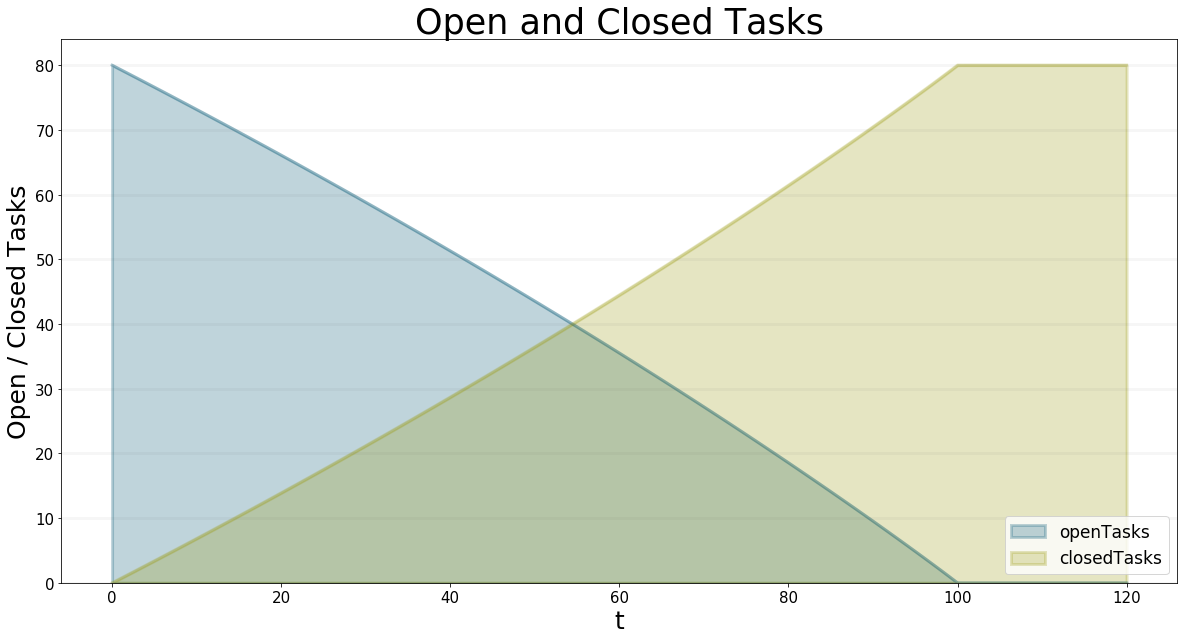

In [21]:
from BPTK_Py.bptk import bptk
bptk = bptk()
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80"],
    equations=['openTasks',"closedTasks"],
    title="Open and Closed Tasks",
    x_label="t",
    y_label="Open / Closed Tasks",
)


### Play with start date and frequency
In the above example, we did not specify the ``freq`` and ``start_date`` parameters. So the series just plots the values of t for the x axis. Using the mentioned parameters you can generate time series data. Let us set ``freq="M"``and ``start_date="1/11/2017"``.
Of course, the graph is the same. But the y-axis changed. Now the plot assumes daily data, starting at Jan, 11, 2017!

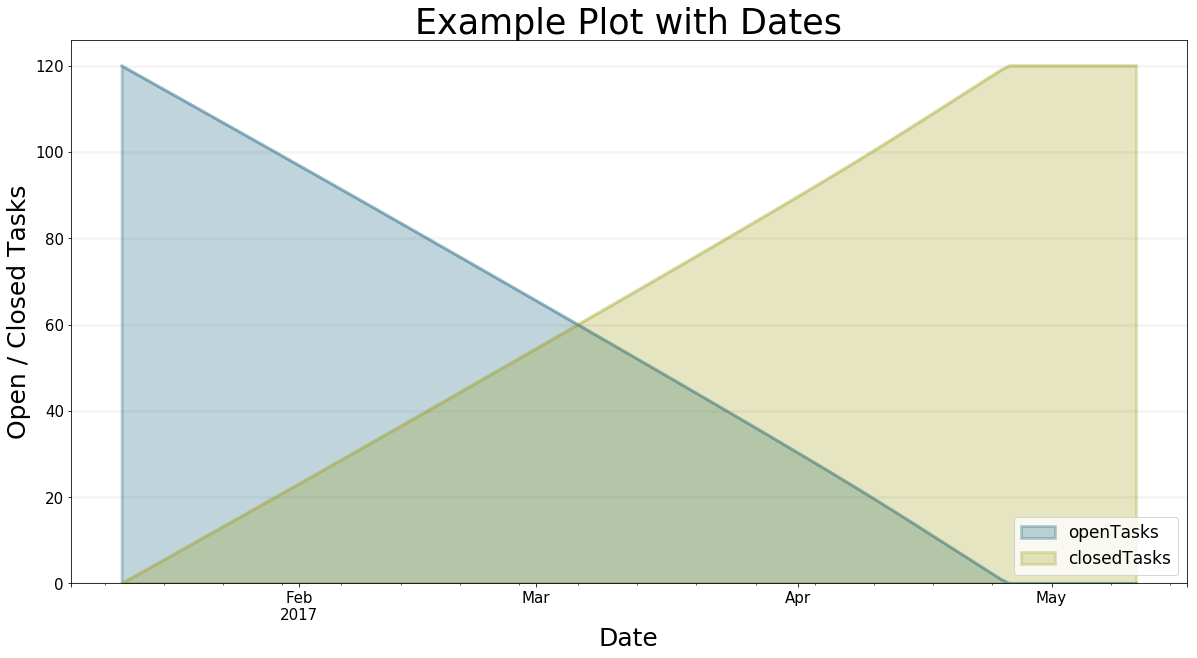

In [3]:

bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"],
    equations=['openTasks',"closedTasks"],
    title="Example Plot with Dates",
    x_label="Date",
    y_label="Open / Closed Tasks",
    start_date="1/11/2017",
    freq="D"
)

### Naming the series
The equation names are not the kind of names we want to show the customer. So let use the ``series_names`` parameter to rename them. Supply the equations to rename and their destination names. Use Python's dict notation: ``{ equation_name : rename_to }``. 

The dictionary serves as a set of replacement rules. To correctly rename the series, you have to understand how the framework sets the names of series to avoid ambiguity in series names. If you use more than one scenario manager for plotting, bptk_py will use the following series naming schema: ``"scenarioManager"_"scenario"_"equation"``. If you want to replace this, use ``series_names={"scenarioManager_scenario_equation": "new name"}``. You may as well define a rule that replaces the name of each scenario Manager with a whitespace. The number of rules is not limited.

Execute the following cell and see how we rename the series:


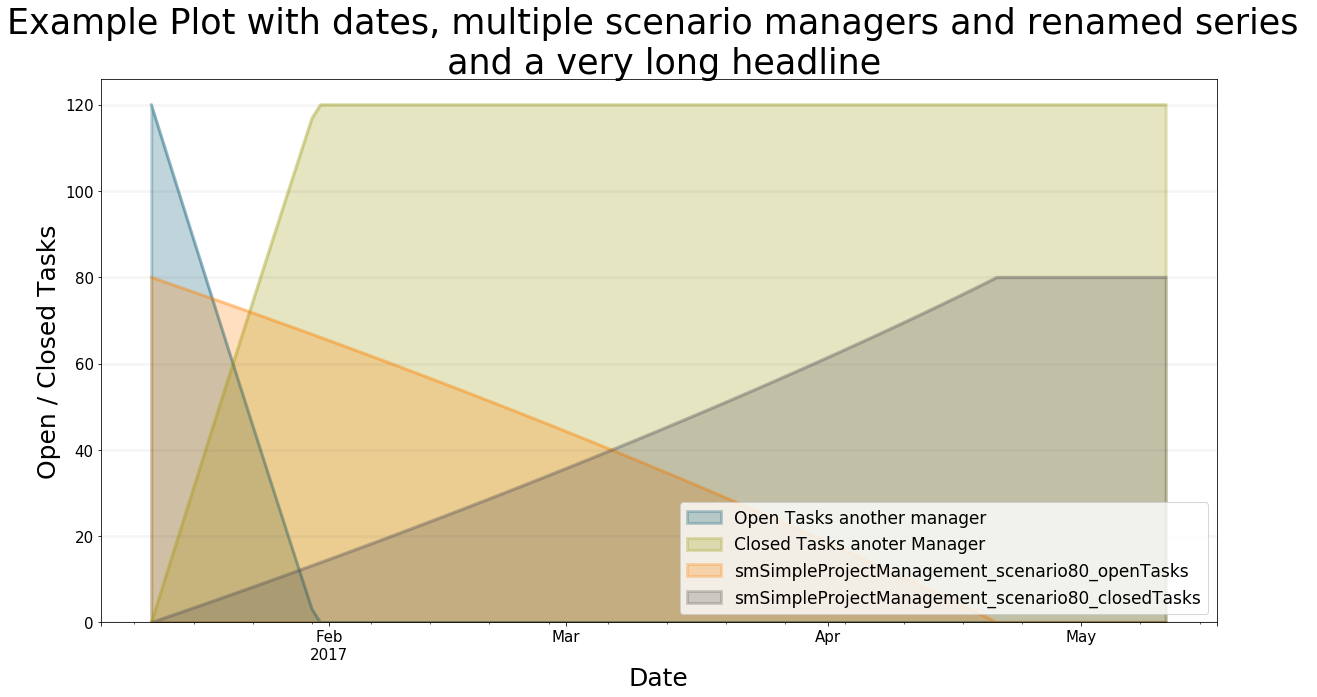

In [4]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement","anotherSimpleProjectManagement"],
    scenarios=["scenario80"],
    equations=['openTasks',"closedTasks"],
    title="Example Plot with dates, multiple scenario managers and renamed series \n and a very long headline",
    x_label="Date",
    y_label="Open / Closed Tasks",
    start_date="1/11/2017",
    freq="D",
    series_names={"anotherSimpleProjectManagement_scenario80_openTasks" : "Open Tasks another manager" , "anotherSimpleProjectManagement_scenario80_closedTasks" : "Closed Tasks anoter Manager",}
)

**Hint**: Did you notice that you may use "\n" to start a new line in the headline? This may come in handy for long plot titles.

## What if I want another kind of graph?
Well, there is the ``kind`` parameter! Let us see what happens if we set ``kind="line"``!


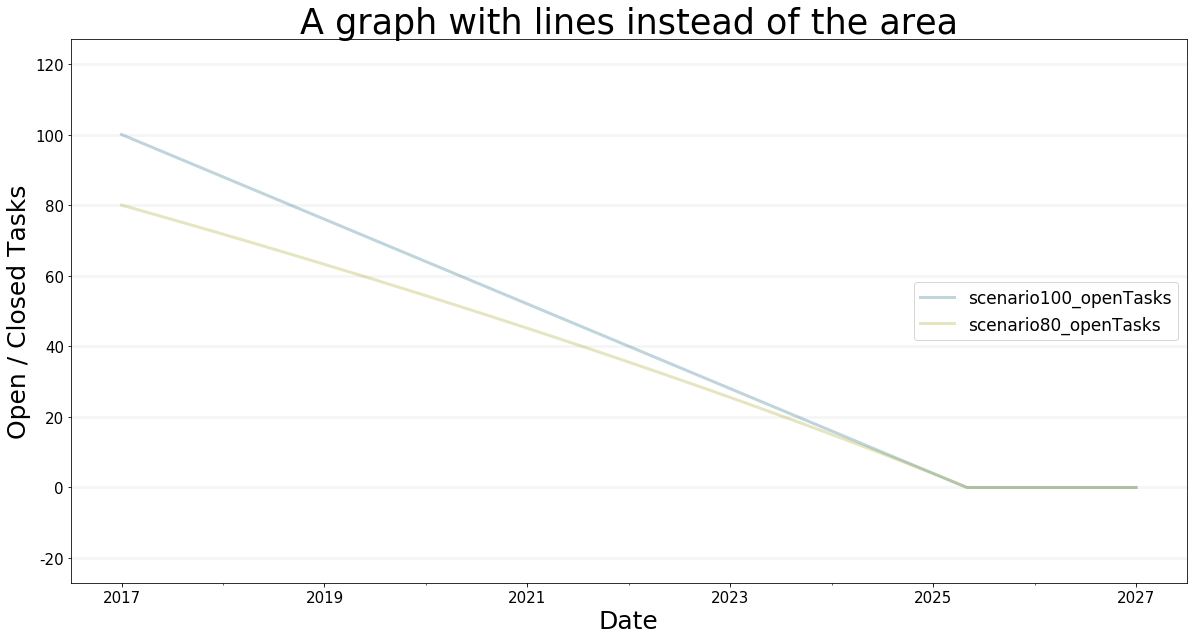

In [5]:
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario100","scenario80"],
    equations=["openTasks"],
    stacked=False, 
    freq="M", 
    start_date="1/11/2017",
    title="A graph with lines instead of the area",
    x_label="Date",
    y_label="Open / Closed Tasks",
    kind="line"
)

## Interactive Plotting
An important part of modelling is to modify values on-the-fly, interactively with the customer. The API function ``bptk.dashboard`` has this functionality. It comes with a field "constants" that contains a list of widget definitions. Each widget is defined using a tuple.
The structure is:  ``("widget_type","name.of.constant",start_value,maximum_value)``. This allows you to see the results of the simulations instantly without having to re-run the simulation manually. See a working example in the following plot.

Currently, we support two types of widgets to control the process:
* **sliders**: Sliders allow you to select a value in an interval. Use "slider" as ``widget_type``. A slider requires ``start_value and maximum_value``. You may use one more value to specify the step size of the slider as a floating point number (optional). If not specified, the slider will use a precision of two decimal places (0.1). Example: ``("slider",'initialOpenTasks',100.0,1000.0,0.01)``.
* **checkbox**: If you want a checkbox, use "checkbox" as ``widget_type``. You do not have to supply ``start_value / maximum_value``. Example: ``("checkbox","initialStaff")``
* **timerange**: This will give you a slider in which you can select time intervals within the graph to "zoom in/out" of certain parts of the graph. It gives you the power to further look into certain simulation periods. It is enough to just add the keyword "timerange" as ``widget_type``.

### Model modifications by dashboard widgets

It is important to mention that everytime you move a slider/checkbox, the underlying model equations are modified. This means, the results of the scenario will also deviate in other plots of the same scenario. You may reuse the modifications to the model in further plots. If this is not what you want,
a quick workaround is to initiliaze another instance of BPTK_Py and run the ``dashboard`` function independently from the other instance(s).



In [6]:
from BPTK_Py.bptk import bptk
bptk = bptk()
bptk.dashboard(scenario_managers=["smSimpleProjectManagement"],
                                scenarios=["scenario100"],
                                kind="area",
                                equations=["openTasks","closedTasks"],
                                stacked=False,
                                strategy=False,
                                freq="D",
                                start_date="1/1/2017",
                                title="Interactive Plotting",
                                x_label="Date",
                                y_label="Open / Closed Tasks",
                                constants=[("slider",'deadline',0.0,1000.0),("slider","effortPerTask",0.0001,1.0,0.0001),("timerange")]
                                )


interactive(children=(FloatSlider(value=500.0, continuous_update=False, description='deadline', layout=Layout(…

## Strategies

The simulator is also able to simulate various execution strategies. A strategy defines which constants change at which point in time of the simulation. For defining a strategy, use the ``strategy`` key in your scenario definition and give (key,value) sets for the constants you'd like to change. Note that the ``constants`` field in the strategy will also be parsed at ``t=0`` for initial modifications of the strategies.
```
  "strategy": {
    "20": {
      "deadline" : 110
    }
  }
```
This strategy reduces the deadline for the project to 110 at the 20th period. The full scenario for this strategy is available in [scenarios/intro.json)](scenarios/make_your_startup_grow_with_strategy.json) in the scenario "scenario120".
To apply a strategy for a scenario, use the parameter ``strategy=True``.Keep in mind that if you defined a strategy in the JSON file and set ``strategy=True`` in the dashboard method, this overrides the sliders in interactive plotting from the point of the first time of the strategy execution.For instance if you define a slider for "deadline", the slider's modification will only have an effect until t=19, as from t=20 the strategy modifies "deadline".

The following plot executes the model with the strategy and shows how the marketing budget follows the configuration the strategy.

**Note:** If you set the ``strategy=True`` but there is not strategy defined in the scenario, the simulator will just issue a Warning in the logfile and execute the simulation(s) without a strategy. 

The following example shows what happens when using the strategy as compared to the scenario without strategy:

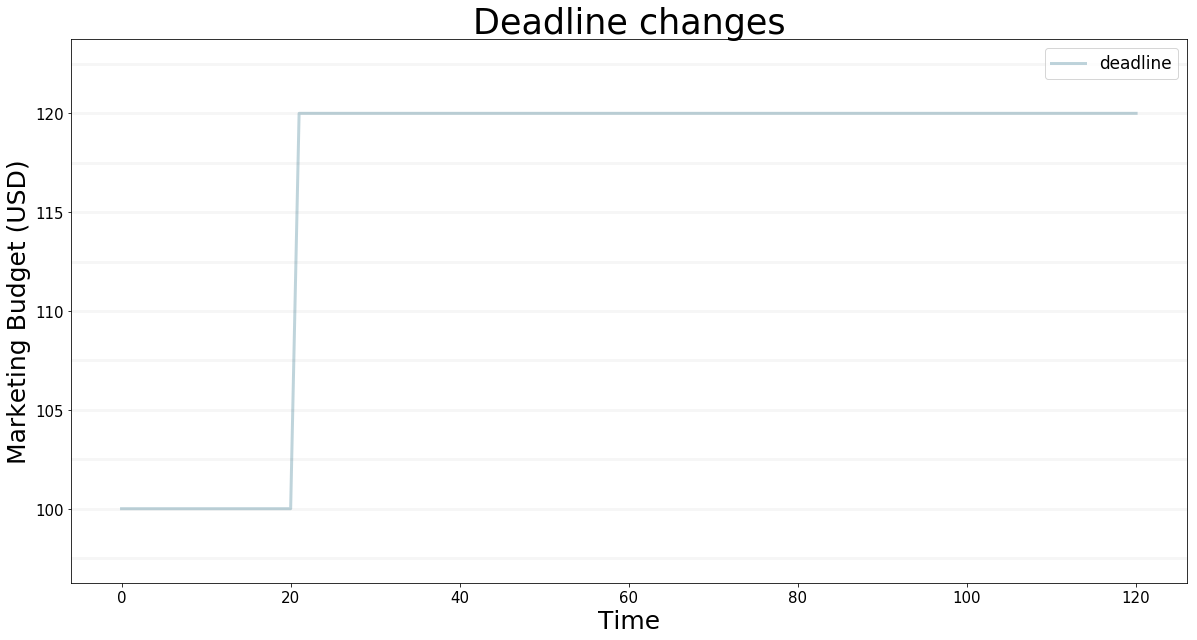

In [7]:
from BPTK_Py.bptk import bptk
bptk = bptk()
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"], 
    equations=["deadline"],
    title="Deadline changes",
    x_label="Time",
    y_label="Marketing Budget (USD)",
    strategy=True, kind="line"
)


## Advanced: Extended Strategies / Manipulation during runtime
Now it gets really interesting and rather complex. The goal is to replace certain equations of the model with custom lambda functions during runtime. This is for advanced use only and currently considered unstable.

First we need to obtain the scenarios and their corresponding simulation models and replace the given equations with the new lambda. 
An extended strategy is just another dictionary. In general, it looks like this:
```
scenarios = bptk.scenario_manager_factory.get_scenarios(scenario_managers=["smSimpleProjectManagement"])

extended_strategy= {
    "scenario80" : {
        "10" : { 
            "initialOpenTasks" : lambda t :0 if t <= 1 else 42 + scenarios["scenario80"].model.memoize("initialOpenTasks",t-1) ,
        }
    }    
}
```
You see that this concept is rather complex and requires understanding of Python. First we have to load all available scenarios. The dictionary contains *pointers* to the specific scenario objects that we loaded from the scenario files. They are stored in the ``ScenarioManager`` object instance of the ``bptk`` object. The lambda functions now have to use these scenarios pointers to receive the pointers to the ``model`` object (and therefore the equations) of the simulation model. 
We will overwrite the specific equations with the given lambda function(s) in the previously-described strategy dictionary of the scenario. It is possible to store lambda functions just like this as strings in JSON **but** the complexity is even higher when it comes to adding it to the model during run-time. As the bptk object uses the same set of scenarios, it will use the same object pointers when we finally issue ``bptk.plot_scenarios(... ,strategy=True)``

We begin with defining the new, extended strategy. It plays a around with the initial open Tasks. It will return 0 if at starttime of the model. Otherwise, it returns the value of t-dt multiplied by 1,000. See also how we get the dt and start time of the model by accessing the scenarios.


In [8]:
from BPTK_Py.bptk import bptk
bptk=bptk()
scenarios = bptk.scenario_manager_factory.get_scenarios(scenario_managers=["smSimpleProjectManagement"])

dt = scenarios["scenario80"].model.dt


extended_strategy= {
    "scenario80" : {
        "10" : { 
            "initialOpenTasks" : lambda t :0 if t <= 1 else 500 + scenarios["scenario80"].model.memoize("initialOpenTasks",t-1) ,
            "deadline" : lambda t : 80
        }
    }    
}

bptk.modify_strategy(scenarios=scenarios,extended_strategy=extended_strategy)



And now we run the method ``bptk.modify_strategy(scenarios,extended_strategy)``. It receives the pointers to the scenarios object and the modifications to the existing strategy. The method will just take the dictionary and fill up the strategy field of the scenario(s) with the lambda function objects.

Please keep in mind that ``bptk`` stores the old lambda function. It runs the simulation until ``t-1``, inserts the new function and continues until the next change. If you want to re-run the scenario with another modified strategy, just flush the ``ScenarioManager``'s ``scenario`` object:
```
bptk.reset_simulation_model(scenario_name="scenario80",scenario_manager="smSimpleProjectManagement")
```
This will cause the scenario manager to reload the scenario's simulation model from the source file.
Finally, you may use the plotting methods with the ``strategy=True`` parameter for simulating and plotting the modified scenarios. 

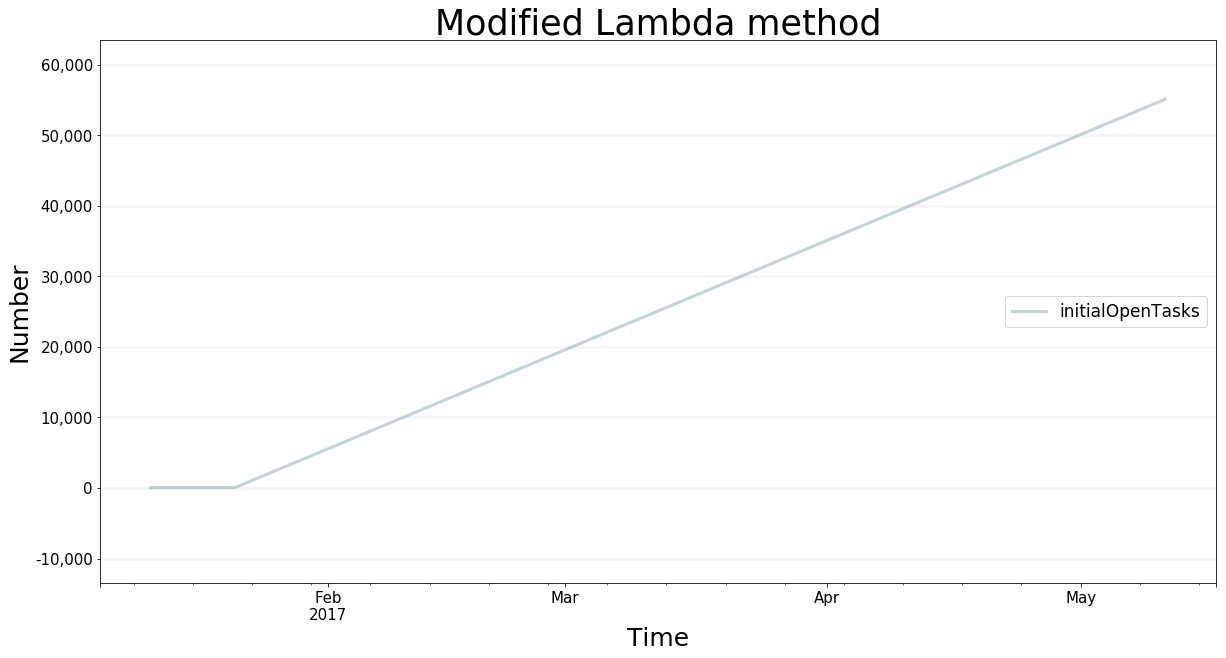

In [9]:
## Plot the graph with the extended stratefy
bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario80"],
    kind="line",
    equations=["initialOpenTasks"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Modified Lambda method",
    x_label="Time",
    y_label="Number"
)

# Create Scenarios during Runtime
It is possible to add scenarios during runtime. For convenience, here is some example code you may use as a template to generate your own scenarios during runtime. If you define multiple scenarios for the same ``scenario_manager``, this is no problem. 

First define the details for the scenario manager and then set up the name of the scenario, the strategy and the constants. The strategy may as well be one of the complex ones as described above. But be careful to define everything correctly. We plan to develop a tool to help you create scenarios a little easier.

In [10]:

from BPTK_Py.bptk import bptk
bptk = bptk()


scenario_manager = {
    "name" : "ScenarioManager_temp",
    "model" : "simulation_models/sd_simple_project",
    "source" : "simulation_models/sd_simple_project.itmx"
}


name = "scenario_160"
strategy = {
            "0": {
                "deadline" : 2000
            } ,
            "20":{
                "deadline" : 800
            }
}
constants = {
            "deadline" : 160,
            "effortPerTask" : 0.1
        }


dictionary ={ scenario_manager["name"]:  
             {
                "model": scenario_manager["model"],
                "source": scenario_manager["source"],
                 name:{
                     "constants" : constants, 
                     "strategy" : strategy
                 } 
             } 
            }


bptk.add_scenario(dictionary=dictionary)



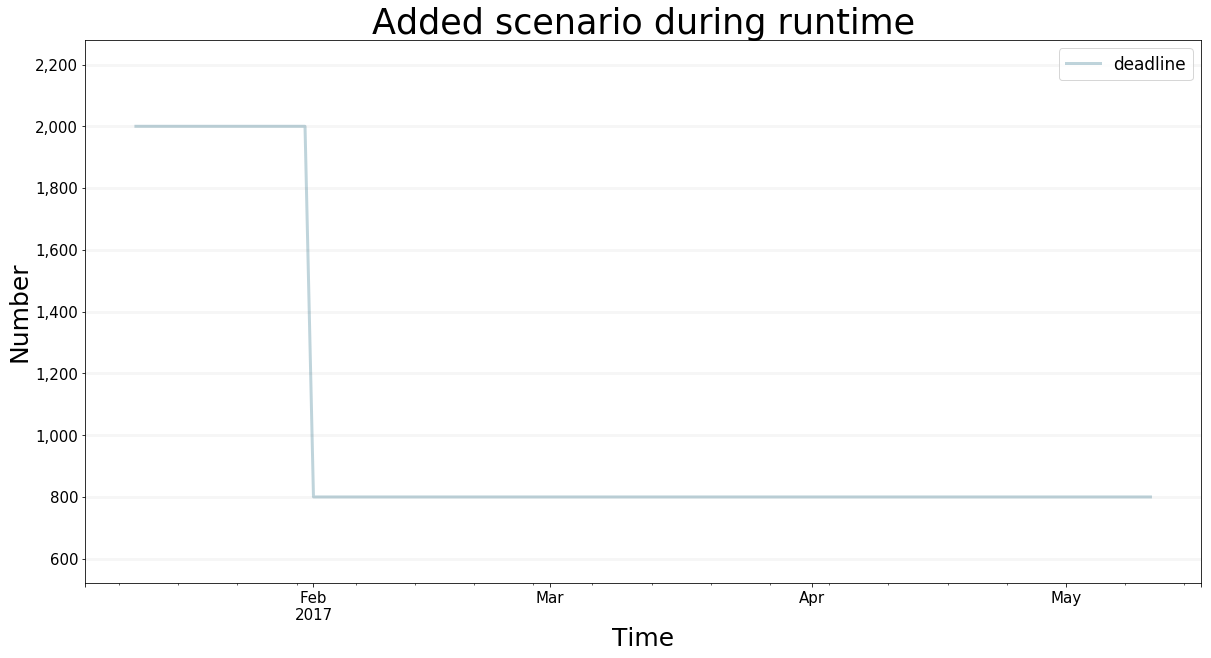

In [11]:
bptk.plot_scenarios(
    scenario_managers=["ScenarioManager_temp"],
    scenarios=["scenario_160"],
    kind="line",
    equations=["deadline"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Added scenario during runtime",
    x_label="Time",
    y_label="Number",
)

## Model Checking
To verify the behavior of the simulator and of the simulation model, it is important to check certain assertions. ``bptk_py`` comes with a simple model checker to verify ``lambda`` functions.

The function is supposed to only return True or False and receives a data parameter. For example ``lambda data : sum(data)/len(data) < 0`` tests if the average of the data is below 0. To obtain the raw output data as required for the model checking, we use the parameter ``return_df=True``. This returns a [dataFrame](https://pandas.pydata.org/pandas-docs/stable/index.html) object. The following example generates this dataframe and uses the model checker to test if the ``productivity`` series' mean is below 0. Otherwise it will return the specified message.


In [12]:
df =bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"],
    kind="line",
    equations=["productivity"],
    stacked=False, 
    strategy=True,
    freq="D", 
    start_date="1/11/2017",
    title="Added scenario during runtime",
    x_label="Time",
    y_label="Number",
    return_df=True
    )

check_function = lambda data : sum(data)/len(data) < 0

bptk.model_check(df["productivity"],check_function,message="Productivity is not <0")

[ERROR] Model Checking failed with message: "Productivity is not <0"


## Resetting the simulation
After a while of simulating, modifying strategies, constants and generating beautiful plots, you may realize that you want to go back and reset the simulation. For this purpose, you have three methods available:
* ``reset_scenario(scenario_manager, scenario)``: This deletes a specific scenario from memory and reloads it from file. Requires the scenario manager's name and the scenario name.
* ``reset_all_scenarios()``: Reset all scenarios and re-read from file
* ``reset_simulation_model(scenario_manager, scenario="")``: For runtime optimizations, the simulator will cache the simulation results. In some rare cases, this cache may not be flushed upon scenario modification. Hence, this method resets the simulation model's cache.

See the example usages below:


In [13]:
bptk.reset_scenario(scenario_manager="smSimpleProjectManagement",scenario="scenario80")

bptk.reset_all_scenarios()

bptk.reset_simulation_model("smSimpleProjectManagement","scenario80")


# Working with the raw data
As we saw in the model checking section, you may obtain the raw simulation results rather than the plot. To activate this feature, use the ``return_df`` flag and set it to ``True``.
The following cell obtains these and stores the values in a variable "df". This way you are able to work with the data outside ``BPTK_Py``!

In [14]:
df = bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"], 
    equations=["openTasks"],
    title="Deadline changes\n",
    x_label="Time",start_date="1/1/2018",freq="M",
    y_label="Marketing Budget (USD)",
    strategy=True, kind="line",
    return_df=True ## <--- HERE
    )

You may want to learn a little about the data. The following code calls the ``head()`` and ``describe()`` functions of the dataFrame. Head return the first 5 elements and Describe gives some important information on the data.
For instance, we learn that there are 121 elements in the dataFrame ("count"). This is correct as the model simulates from t=0 to t=120. Further values are the mean, standard deviation, min, max and the 25th / 50th and 75th percentile.

In [15]:
print("***************************")
print("Properties of the dataFrame")
print("\t first 5 elements:")
print(df.head())
print("")
print("Main description of the dataFrame")
print(df.describe())

***************************
Properties of the dataFrame
	 first 5 elements:
             openTasks
2018-01-31  120.000000
2018-02-28  118.904800
2018-03-31  117.809096
2018-04-30  116.712881
2018-05-31  115.616145

Main description of the dataFrame
        openTasks
count  121.000000
mean    59.206097
std     34.631392
min      0.000301
25%     29.718955
50%     59.126251
75%     88.307244
max    120.000000



To select only certain periods, you may use two different approaches. 
1. Go by t and use the list index representation
2. Go by date (if you created a time series using ``start_date``)

In both cases, you need to supply square brackets and the selected range:

In [16]:
# Select 06 first months
by_index = df[0:6] 

# Select all values of the months January to June 2018:
by_year = df["2018-01":"2018-06"]

print("BY INDEX")
print(by_index)

print("")
print("BY YEAR-MONTH:")
print(by_year)

print("")
print("CHECK FOR EQUALITY OF BOTH")
print(by_index == by_year)

BY INDEX
             openTasks
2018-01-31  120.000000
2018-02-28  118.904800
2018-03-31  117.809096
2018-04-30  116.712881
2018-05-31  115.616145
2018-06-30  114.518882

BY YEAR-MONTH:
             openTasks
2018-01-31  120.000000
2018-02-28  118.904800
2018-03-31  117.809096
2018-04-30  116.712881
2018-05-31  115.616145
2018-06-30  114.518882

CHECK FOR EQUALITY OF BOTH
            openTasks
2018-01-31       True
2018-02-28       True
2018-03-31       True
2018-04-30       True
2018-05-31       True
2018-06-30       True


Now you even saw how easy it was to check for value equality, just issue ``by_index == by_year``. The return type is a ``Series`` again and you may use it for further computations if assigned to a variable.
Let us now simulate the equation "closedTasks" and generate a second dataFrame for and append it to the existing dataFrame:

In [17]:
df_closed = bptk.plot_scenarios(
    scenario_managers=["smSimpleProjectManagement"],
    scenarios=["scenario120"], 
    equations=["closedTasks"],
    title="Deadline changes\n",
    x_label="Time",start_date="1/1/2018",freq="M",
    y_label="Tasks",
    strategy=True, kind="line",return_df=True
    )


df["closedTasks"] = df_closed["closedTasks"]

You see how easy it was to add the series "closedTasks" of ``df_closed`` to ``df``. Similarly, we may create new series using computation:

In [18]:
df["initialOpenTasks"] = df["openTasks"] + df["closedTasks"]
print(df["initialOpenTasks"].head())

2018-01-31    120.0
2018-02-28    120.0
2018-03-31    120.0
2018-04-30    120.0
2018-05-31    120.0
Freq: M, Name: initialOpenTasks, dtype: float64


As you see, the DataFrame makes sure to make an addition for each value of the series.
Every value should now be 120, just like the initial number of tasks of the scenario ``scenario120``.
As a last example, let us now compute the percentage of tasks closed:

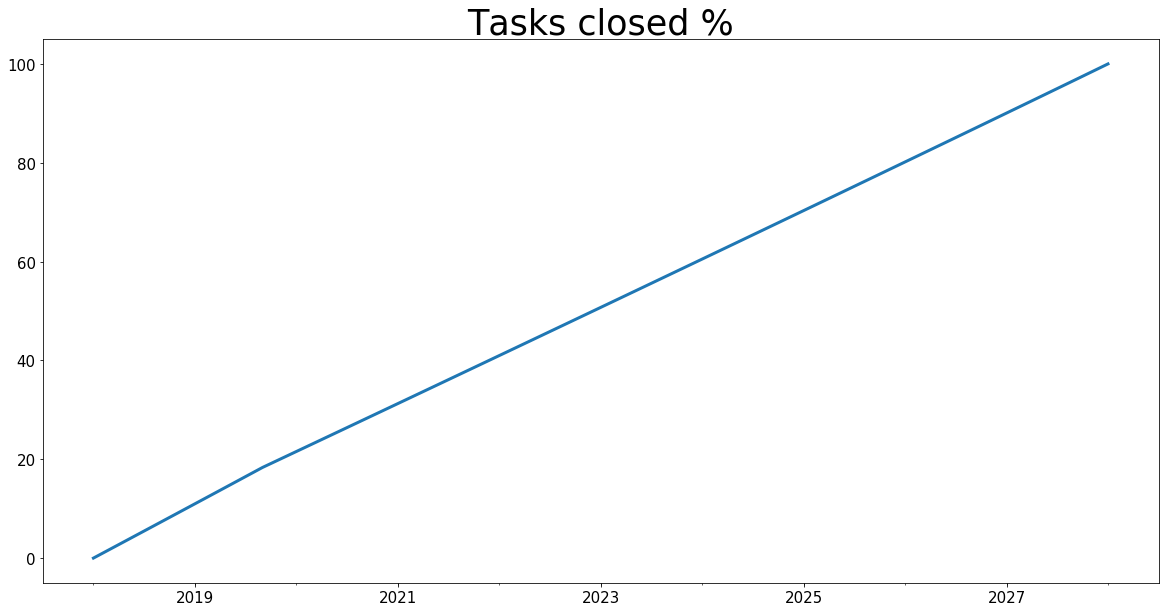

In [19]:
df["Percent Tasks Closed"] = df["closedTasks"] / df["initialOpenTasks"] * 100

### and plot it:
df["Percent Tasks Closed"].plot(title="Tasks closed %")

And let us now print all data we generated:

In [20]:
df

,openTasks,closedTasks,initialOpenTasks,Percent Tasks Closed
2018-01-31,120.000000,0.000000,120.0,0.000000
2018-02-28,118.904800,1.095200,120.0,0.912667
2018-03-31,117.809096,2.190904,120.0,1.825753
2018-04-30,116.712881,3.287119,120.0,2.739266
2018-05-31,115.616145,4.383855,120.0,3.653212
2018-06-30,114.518882,5.481118,120.0,4.567599
2018-07-31,113.421082,6.578918,120.0,5.482432
2018-08-31,112.322737,7.677263,120.0,6.397719
2018-09-30,111.223838,8.776162,120.0,7.313469
2018-10-31,110.124375,9.875625,120.0,8.229687


You may use ``df.to_csv("filename")`` to save the data to a CSV file :-)